In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection

In [2]:
# load dataset from from sklearn
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
print(type(digits.data))
print(type(digits.images))
print(digits.images.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1797, 8, 8)


In [3]:
# define color
yellow = 1
green = 0.7

# 3. Data Preparation

In [4]:
def select_by_y(X, Y, selection):
    """
    select instances whose y is in selection
    Args:
        X: feature set
        Y: response(target) set
        selection: list of target value
    """
    N = len(X)
    new_X = []
    new_Y = []
    for i in range(N):
        if Y[i] in selection:
            new_X.append(X[i])
            new_Y.append(Y[i])
    return np.asarray(new_X),np.asarray(new_Y)

# select instances whose target are "1" and "7"
X_all, Y_all = select_by_y(digits.data, digits.target, [1, 7])
print("the numebr of instances is", len(X_all))

# split data set into training data and test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.4, random_state=0)
print("number of instances in traning data:", len(X_train))
print("number of instances in test data:", len(X_test))

the numebr of instances is 361
number of instances in traning data: 216
number of instances in test data: 145


<span style =" color : green ;font - weight : bold ">In our solution, we directly use model_selection.train_test_split from sklearn which can split the data as required. </span >

## 3.1 Dimension Reduction
* choose two pixels that seem to have a big influence
* come up with some clever combination of the 64 original pixel values into 2 features

In [5]:
X_train_1, _ = select_by_y(X_train, Y_train, [1])
X_train_7, _ = select_by_y(X_train, Y_train, [7])

# calculate the mean of all instances of 1 and 7 respectively
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)

# mean_1_image = mean_1.reshape((8,8))
# mean_7_image = mean_7.reshape((8,8))
# def show_image(image):
#     plt.figure()
#     plt.gray()
#     plt.imshow(image, interpolation="nearest")
#     plt.show()
# show_image(mean_1_image)
# show_image(mean_7_image)

# select the most influential K dimensions
def topK_important_dimension(mean_a, mean_b, K):
    N = len(mean_a)
    assert K<=N
    return np.argsort(np.absolute(np.subtract(mean_a, mean_b)))[N-K:]

dims = topK_important_dimension(mean_1, mean_7, 2)

def reduce_dim(X):
    N = len(X)
    return X[:,dims] # take the most 2 important dimensions

X_all = reduce_dim(X_all)
X_train = reduce_dim(X_train)
X_test = reduce_dim(X_test)
X_train_1 = reduce_dim(X_train_1)
X_train_7 = reduce_dim(X_train_7)
#print(X_train)


<span style =" color : green ;font - weight : bold "> 
    The algorithm we used for dimenstion reduction is different but proved effective.   
    We chose two pixels whose mean value difference is the largest between the two classes.
</span >

## 3.2 Scatterplot

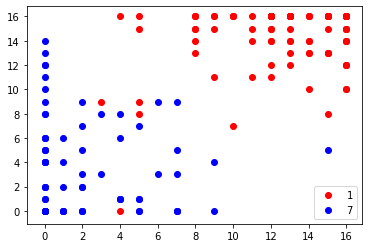

In [6]:
plt.scatter(X_train_1[:,0].transpose(), X_train_1[:,1].transpose(), c='r', label="1")
plt.scatter(X_train_7[:,0].transpose(), X_train_7[:,1].transpose(), c='b', label="7")
plt.legend()
plt.show()

<span style =" color : green ;font - weight : bold ">  
    First, we didn't use different markers but only two different colors to show the points. In professor's solution, 'o' and 'x' are used to denote 1 and 7 respectively.  
    Second, in our solution, many points overlap. But in professor's solution, the the points don't overlap much because of a good dimension reduction method.
</span >

# 4. Nearest Mean

## 4.1 Implement the nearest mean classifier

In [7]:
def dist_vec(training, test):
    """
    calculate the distance matrix using vectorization method
    """
    training_square = np.sum(training*training, axis=1, keepdims=True)
    test_square = np.sum(test*test, axis=1, keepdims=True).T
    distances = np.dot(training, test.T)
    distances *= -2
    distances += training_square
    distances += test_square
    np.maximum(distances, 0, distances)
    np.sqrt(distances, distances)
    return distances

def nearest_mean(training_features, training_labels, test_features):
    """
    predict by nearest mean
    """
    train_1, _ = select_by_y(training_features, training_labels, [1]) # training features whose label is 1
    train_7, _ = select_by_y(training_features, training_labels, [7]) # training features whose label is 7
    mean_1 = np.mean(train_1, axis=0)
    mean_7 = np.mean(train_7, axis=0)
    mean_matrix = np.vstack((mean_1, mean_7))
    distance_matrix = dist_vec(mean_matrix, test_features) # distance matrix: 2*M (M is the number of instances in test set)
    sorted_distance_indices = np.argsort(distance_matrix, axis=0)
    nearest_indices = sorted_distance_indices[0,:]
    return np.asarray([1,7]).take(nearest_indices)

def cal_err(Y_test, Y_pred):
    """calculate the error rate"""
    return np.sum((Y_test - Y_pred)!=0)/Y_pred.size
    
Y_pred = nearest_mean(X_train, Y_train, X_test)
print(cal_err(Y_test, Y_pred))
    
# a = np.asarray([1,7])
# print(a.take([0,1,1,1,1]))

0.006896551724137931


<span style =" color : green ;font - weight : bold "> 
    The Nearest Mean algorithm we implement is correct and it's entirely based on matrix operations.
</span >

## 4.2 Visualize the decision regions

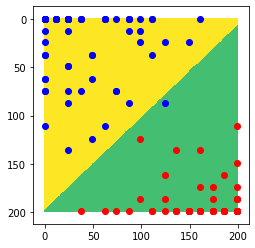

In [8]:
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)
def predict_NM(X): # X: 1*2 vector
    distance_1 = np.sqrt(np.sum(np.subtract(X, mean_1)**2))
    distance_7 = np.sqrt(np.sum(np.subtract(X, mean_7)**2))
    if distance_1 < distance_7:
        return 1
    else:
        return 7

def decision_region():
    image = np.zeros((200, 200))
    step = 16 / (200-1)
    for i in range(200):
        for j in range(200):
            x1 = i*step
            x0 = j*step
            if predict_NM([x0,x1]) == 1:
                image[i][j] = green
            else :
                image[i][j] = yellow
    return image


X_test_draw_1, _ = select_by_y((X_test*199/16).astype(int), Y_test, [1])
X_test_draw_7, _ = select_by_y((X_test*199/16).astype(int), Y_test, [7])

plt.figure()
plt.imshow(decision_region(), vmin=0, vmax=1)
plt.scatter(X_test_draw_1[:,0], X_test_draw_1[:,1], c="r")
plt.scatter(X_test_draw_7[:,0], X_test_draw_7[:,1], c="b")
plt.show()
  
    

<span style =" color : green ;font - weight : bold "> 
    The decision boundary we draw is clear and can easily seperate the two classes with a high accuracy.  
    Again, we need to use different markers for different classes.
</span >

## Cross Validation

In [9]:
from sklearn.model_selection import KFold

def cross_validation_NM(X, Y):
    errs = []
    kf = KFold(n_splits=10)
    for train, test in kf.split(X):
        # print("train:", train, "test:", test)
        X_train_cv = X[train]
        X_test_cv = X[test]
        Y_train_cv = Y[train]
        Y_test_cv = Y[test]
        pred_cv = nearest_mean(X_train_cv, Y_train_cv, X_test_cv)
        err = cal_err(pred_cv, Y_test_cv)
        errs.append(err)
    return errs

errs = cross_validation_NM(X_all, Y_all)
print(errs)
NM_error = np.mean(errs)
print("mean error: ", NM_error)

[0.02702702702702703, 0.05555555555555555, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.027777777777777776, 0.0, 0.0]
mean error:  0.01659159159159159


# QDA
## 5.1 Implement QDA Training

$$\hat{\mu}_k = \frac{1}{N_k}\Sigma_{i:y_i=k}x_i$$
$$\hat{\Sigma_k} = \frac{1}{N_k}\Sigma_{i:y_i=k}(x_i-\mu_k)^T(x_i-\mu_k)$$
$x_i$ is the i th instance

In [10]:
def fit_qda(training_features, training_labels):
    D = training_features.shape[1]  # dimensions of training data
    X_0, _ = select_by_y(training_features, training_labels, [1])
    X_1, _ = select_by_y(training_features, training_labels, [7])
    mu = np.vstack((np.mean(X_0, axis=0), np.mean(X_1, axis=0)))
    covmat = np.zeros((2,D,D))
    for i in range(len(X_0)):
        covmat[0] += 1/len(X_0)* np.mat(X_0[i]-mu[0]).T * np.mat(X_0[i]-mu[0])
    for i in range(len(X_1)):
        covmat[1] += 1/len(X_1)* np.mat(X_1[i]-mu[1]).T * np.mat(X_1[i]-mu[1])
    prior = [len(X_0)/len(training_features), len(X_1)/len(training_features)]
    return mu, covmat, prior


calculate $\mu, \Sigma$ and priors

In [11]:
mu, covmat, p = fit_qda(X_train, Y_train)

<span style =" color : green ;font - weight : bold "> 
    We calculate the covariance matrix by the formula given in the class.  
    But in professor's solution, it can be computed by simply call function cov from numpy! Didn't expect it to be so easy.
</span >

## 5.2 Implement QDA Prediction

In [12]:
def predict_qda(mu, covmat, p, test_features):
    M = len(test_features)
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[0])) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[1])) - np.log(p[1])
    likelihoods = np.zeros((2, M))
    for i in range(M):
        likelihoods[0][i] = (1/2)*np.mat(test_features[i]-mu[0])*np.linalg.inv(covmat[0])*np.mat(test_features[i]-mu[0]).T + b_0
        likelihoods[1][i] = (1/2)*np.mat(test_features[i]-mu[1])*np.linalg.inv(covmat[1])*np.mat(test_features[i]-mu[1]).T + b_1
    sorted_indices = np.argsort(likelihoods, axis=0)
    return sorted_indices[0, :]

# make prediction
train_prediction5 = predict_qda(mu, covmat, p, X_train)
train_Y_pred5 = np.asarray([1,7]).take(train_prediction5)  # map 0,1 in predictions to real response value "1" and "7"
print("error rate of training set:",cal_err(train_Y_pred5, Y_train))

# make prediction
test_prediction5 = predict_qda(mu, covmat, p, X_test)
test_Y_pred5 = np.asarray([1,7]).take(test_prediction5)  # map 0,1 in predictions to real response value "1" and "7"
print("error rate of test set:",cal_err(test_Y_pred5, Y_test))


error rate of training set: 0.027777777777777776
error rate of test set: 0.006896551724137931


<span style =" color : green ;font - weight : bold "> 
    The QDA prediction is correct. Professor's solution is more elegent because another function log_likelihood is introduced.
</span >

## 5.3 Visualization

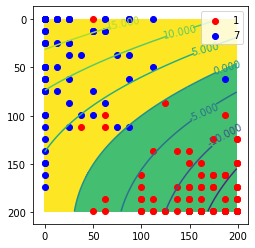

In [13]:
N_image = 200
image = np.zeros((N_image, N_image))
step = 16 / (N_image-1)
for i in range(N_image):
    for j in range(N_image):
        x1 = i*step
        x0 = j*step
        if predict_qda(mu, covmat, p, [[x0,x1]]) == 0:
            image[i][j] = green
        else :
            image[i][j] = yellow
            

def qda_contour(mu, covmat, p):
    x0 = np.arange(0,200,1)
    x1 = np.arange(0,200,1)
    X0, X1 = np.meshgrid(x0, x1)
    X = [[X0[i], X1[i]] for i in range(len(X0))]
    Z = np.zeros(X0.shape)
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[0])) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[1])) - np.log(p[1])
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x = np.asarray([X0[i][j]*step, X1[i][j]*step])
            likelihoods0 = (1/2)*np.mat(x-mu[0])*np.linalg.inv(covmat[0])*np.mat(x-mu[0]).T + b_0
            likelihoods1 = (1/2)*np.mat(x-mu[1])*np.linalg.inv(covmat[1])*np.mat(x-mu[1]).T + b_1
            Z[i][j] = likelihoods0 - likelihoods1
    return X0, X1, Z


X_train_draw_1, _ = select_by_y((X_train*(1/step)), Y_train, [1])
X_train_draw_7, _ = select_by_y((X_train*(1/step)), Y_train, [7])

X0, X1, Z = qda_contour(mu, covmat, p)

plt.figure()
plt.imshow(image, vmin=0, vmax=1)
CS = plt.contour(X0, X1, Z)
plt.clabel(CS, inline=5)
plt.scatter(X_train_draw_1[:,0], X_train_draw_1[:,1], c="r", label="1")
plt.scatter(X_train_draw_7[:,0], X_train_draw_7[:,1], c="b", label="7")
plt.legend()
plt.show()

<span style =" color : green ;font - weight : bold "> 
    We failed to draw the cluster shape. We drawed a contour the show the boundary line but it's not the cluster shape. What we need to do is to apply the parameters to the distribution function then use contour in matplotlib to get the cluster shape.
</span >

## 5.4 Performance evaluation 

In [14]:
from sklearn.model_selection import KFold

def cross_validation(X, Y, fit, predict):
    errs = []
    kf = KFold(n_splits=10)
    for train, test in kf.split(X):
        # print("train:", train, "test:", test)
        X_train_cv = X[train]
        X_test_cv = X[test]
        Y_train_cv = Y[train]
        Y_test_cv = Y[test]
        mu_cv, covmat_cv, p_cv = fit(X_train_cv, Y_train_cv)
        pred_cv = np.asarray([1,7]).take(predict(mu_cv, covmat_cv, p_cv, X_test_cv))
        err = cal_err(pred_cv, Y_test_cv)
        errs.append(err)
    return errs
    
errs = cross_validation(X_all, Y_all, fit_qda, predict_qda)
print(errs)
QDA_error = np.mean(errs)
print("mean err:", QDA_error)

[0.02702702702702703, 0.1111111111111111, 0.0, 0.027777777777777776, 0.0, 0.0, 0.0, 0.027777777777777776, 0.0, 0.0]
mean err: 0.019369369369369373


<span style =" color : green ;font - weight : bold "> 
    In performance evaluation, we only gave the mean of error rate and forgot to calculate the standard deviation.  
    The final result should be in the form of mean +/- variance.
</span >

# 6 LDA
$$\Sigma_w = \frac{1}{N}\Sigma_{i=1}^{N}(x_i-\mu_{y_i})^T(x_i-\mu_{y_i})$$

## fit and predict

In [15]:
def fit_lda(training_features, training_labels):
    D = training_features.shape[1]  # dimensions of training data
    X_0, _ = select_by_y(training_features, training_labels, [1])
    X_1, _ = select_by_y(training_features, training_labels, [7])
    mu = np.vstack((np.mean(X_0, axis=0), np.mean(X_1, axis=0)))
    covmat = np.zeros((D,D))
    for i in range(len(X_0)):
        covmat += 1/len(X_0)* np.mat(X_0[i]-mu[0]).T * np.mat(X_0[i]-mu[0])
    for i in range(len(X_1)):
        covmat += 1/len(X_1)* np.mat(X_1[i]-mu[1]).T * np.mat(X_1[i]-mu[1])
    prior = [len(X_0)/len(training_features), len(X_1)/len(training_features)]
    return mu, covmat, prior
    
def predict_lda(mu, covmat, prior, test_features):
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[1])
    b_0 += (1/2)*np.mat(mu[0])*np.mat(covmat)*np.mat(mu[0]).T
    b_1 += (1/2)*np.mat(mu[1])*np.mat(covmat)*np.mat(mu[1]).T
    b = b_0 - b_1
    W = np.mat(mu[1]-mu[0])*np.mat(covmat)
    predicted = np.mat(W)*np.mat(test_features).T + b
    predicted = predicted>0
    predicted = predicted + 0
    return predicted
    
mu, covmat, p = fit_lda(X_train, Y_train)


# make prediction
train_prediction6 = predict_lda(mu, covmat, p, X_train)
train_Y_pred6 = np.asarray([1,7]).take(train_prediction6)  # map 0,1 in predictions to real response value "1" and "7"
print("error rate of training set:",cal_err(train_Y_pred6, Y_train))

# make prediction
test_prediction6 = predict_lda(mu, covmat, p, X_test)
test_Y_pred6 = np.asarray([1,7]).take(test_prediction6)  # map 0,1 in predictions to real response value "1" and "7"
print("error rate of test set:",cal_err(test_Y_pred6, Y_test))


error rate of training set: 0.023148148148148147
error rate of test set: 0.006896551724137931


## Visualization

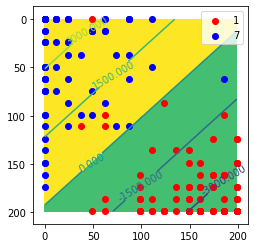

In [20]:
N_image = 200
image = np.zeros((N_image, N_image))
step = 16 / (N_image-1)
for i in range(N_image):
    for j in range(N_image):
        x1 = i*step
        x0 = j*step
        if predict_lda(mu, covmat, p, [[x0,x1]]) == 0:
            image[i][j] = green
        else :
            image[i][j] = yellow
            

def lda_contour(mu, covmat, p):
    x0 = np.arange(0,200,1)
    x1 = np.arange(0,200,1)
    X0, X1 = np.meshgrid(x0, x1)
    Z = np.zeros(X0.shape)
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[1])
    b_0 += (1/2)*np.mat(mu[0])*np.mat(covmat)*np.mat(mu[0]).T
    b_1 += (1/2)*np.mat(mu[1])*np.mat(covmat)*np.mat(mu[1]).T
    b = b_0 - b_1
    W = np.mat(mu[1]-mu[0])*np.mat(covmat)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i][j] = np.mat(W)*np.mat([X0[i][j]*step, X1[i][j]*step]).T + b
    return X0, X1, Z


X_train_draw_1, _ = select_by_y((X_train*(1/step)).astype(int), Y_train, [1])
X_train_draw_7, _ = select_by_y((X_train*(1/step)).astype(int), Y_train, [7])

X0, X1, Z = lda_contour(mu, covmat, p)

plt.figure()
plt.imshow(image, vmin=0, vmax=1)
CS = plt.contour(X0, X1, Z)
plt.clabel(CS, inline=1)
plt.scatter(X_train_draw_1[:,0], X_train_draw_1[:,1], c="r", label="1")
plt.scatter(X_train_draw_7[:,0], X_train_draw_7[:,1], c="b", label="7")
plt.legend()
plt.show()

## Cross Validation

In [17]:
errs = cross_validation(X_all, Y_all, fit_lda, predict_lda)
print(errs)
LDA_error = np.mean(errs)
print("mean err:", LDA_error)

[0.02702702702702703, 0.05555555555555555, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.027777777777777776, 0.0, 0.0]
mean err: 0.01659159159159159


In [18]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
err_dict = {
    "method":["Nearest Mean", "QDA", "LDA"],
    "error":[NM_error, QDA_error, LDA_error]
}
df = pd.DataFrame(err_dict)
df.set_index("method", inplace=True)
display(df)

,error
method,
Nearest Mean,0.0166
QDA,0.0194
LDA,0.0166


From the chart above, we can see in the data set we use LDA is better than QDA and similar to Nearest Mean.

<span style =" color : green ;font - weight : bold "> 
    The problems we had in our solution in LDA is similar to those in QDA.  
    First, the calculation of covariance matrix can be computed by call cov function from numpy.  
    Second, we failed to draw the cluster shape and need to apply the parameters to the distribution function.
    Third, we forgot to calculate the standard deviation in cross validation part.
</span >